In [1]:
import re
import pandas as pd
from tqdm import tqdm

In [2]:
from strsimpy.jaro_winkler import JaroWinkler

jarowinkler = JaroWinkler()

print(jarowinkler.similarity('mayo', 'yam'))

0.5277777777777778


In [3]:
regex = "([0-9]*\.?[0-9]*)(?: *)?([a-z]*)(?: *)?(?:of )?(.*)"

test_regex = re.compile(regex)

In [4]:
import nltk
gram = ("NP: {<VB.*|JJ>?<N.*>*}")

In [5]:
df_INQ = pd.read_csv('df_INQ_test_cleaned.csv')
df_ingredients = pd.read_csv('df_ingredients_clean.csv')

df_INQ.drop(columns=['Unnamed: 0'], inplace= True)
df_ingredients.drop(columns=['Unnamed: 0'], inplace= True)

df_INQ_agged = df_INQ.groupby('ID', as_index=False).agg(pd.Series.tolist)
df_ingredients_agged = df_ingredients.groupby('ID', as_index=False).agg(pd.Series.tolist)

In [6]:
units = ['assortment',
 'bag',
 'bags',
 'ball',
 'balls',
 'bar',
 'bars',
 'basket',
 'baskets',
 'batch',
 'blades',
 'block',
 'bone',
 'bottle',
 'bottles',
 'bowl',
 'bowls',
 'box',
 'boxes',
 'bulb',
 'bulbs',
 'bunch',
 'bunches',
 'can',
 'canister',
 'cans',
 'carton',
 'cartons',
 'chunk',
 'chunks',
 'clove',
 'cloves',
 'container',
 'containers',
 'cube',
 'cubes',
 'cup',
 'cups',
 'dash',
 'dashes',
 'drop',
 'drops',
 'ear',
 'ears',
 'flatout',
 'fluid ounces',
 'foot',
 'g',
 'gallon',
 'gallons',
 'gram',
 'grams',
 'handful',
 'head',
 'heads',
 'inch',
 'inches',
 'jar',
 'jars',
 'kg',
 'knob',
 'lb',
 'leaf',
 'leaves',
 'length',
 'lengths',
 'liter',
 'liters',
 'loaf',
 'loaves',
 'log',
 'logs',
 'lump',
 'mg',
 'milliliter',
 'minute',
 'ml',
 'neck',
 'ounce',
 'ounces',
 'oval',
 'oz',
 'package',
 'packaged',
 'packages',
 'packet',
 'packets',
 'peel',
 'peels',
 'piece',
 'pieces',
 'pinch',
 'pinches',
 'pint',
 'pints',
 'pitted',
 'pkg',
 'pocket',
 'pod',
 'pods',
 'portions',
 'pot',
 'pouch',
 'pouches',
 'pound',
 'pounds',
 'quart',
 'quarts',
 'rack',
 'racks',
 'ring',
 'rings',
 'roll',
 'rolls',
 'round',
 'scoop',
 'scoops',
 'serving',
 'servings',
 'set',
 'sheet',
 'sheets',
 'shells',
 'shot',
 'shots',
 'skewers',
 'slab',
 'slabs',
 'sleeve',
 'sleeves',
 'slice',
 'slices',
 'spears',
 'splash',
 'splashes',
 'spray',
 'sprays',
 'sprinkle',
 'square',
 'squares',
 'squeeze',
 'squeezes',
 'squirts',
 'stalk',
 'stalks',
 'star',
 'stems',
 'stewing',
 'stick',
 'sticks',
 'store',
 'strands',
 'straw',
 'strip',
 'strips',
 'tablespoon',
 'tablespoons',
 'tablet',
 'tablets',
 'teaspoon',
 'teaspoons',
 'tins',
 'tray',
 'trays',
 'tub',
 'tube',
 'tubes',
 'tubs',
 'twist',
 'twists',
 'wedge',
 'wedges',
 'wheel',
 'wheels',
 'wrap',
 'wraps',
 'tbsp',
 'tsp',
 'l',
 'g',
 'tbsps',
 'tsps',
 'cm',
 'tin', 
 'milliliters',]

In [7]:
df_ingredients_with_notes = pd.read_csv('ingredients_PCA_with_notes.csv')
df_ingredients_with_notes.drop(columns=['Unnamed: 0'], inplace= True)

In [8]:
df_ingredients_with_notes

,ID,Ingredients,match,order,note
0,1,gochujang base,gochujang base,2,Perfect
1,1,ketchup,ketchup,1,Perfect
2,1,maple syrup,maple syrup,2,Perfect
3,1,soy sauce,soy sauce,2,Perfect
4,1,seasoned rice wine vinegar,seasoned rice wine vinegar,4,Perfect
...,...,...,...,...,...
26173,902,banana,banana,1,Perfect
26174,902,almond milk,almond milk,2,Perfect
26175,902,packet frozen acai,za'atar,0,Not perfect
26176,903,banana,banana,1,Perfect


In [11]:
import json

with open('tree.json') as json_file:
    dict_tree = json.load(json_file)

In [12]:
from strsimpy import Cosine
from itertools import permutations

cos = Cosine(1)

def find(s, trees, order, steps):
    max_order = s.split(' ')
    candidates = []
    
    if order < len(s.split(' ')):
        
        for i in permutations(s.split(' '), order):
            for tree in trees:
                candidate = tree.get(' '.join(i))
                if candidate is not None:
                    steps.append((' '.join(i), order))
                    candidates.append(candidate)
 
        if not candidates:
            
            if any([not(tree.keys()) for tree in trees]):
                
                return steps[-1]
            
            sim_score = float('-inf')
            
            for i in permutations(s.split(' '), order):
                for tree in trees:
                    candidates = tree.keys()
                    for key in candidates:
                        if jarowinkler.similarity(' '.join(i), key) > sim_score:
                            sim_score = jarowinkler.similarity(s, key)
                            best_key = key
                steps.append((best_key, order - 1))
            
            return steps[-1]
            
        find(s, candidates, order+1, steps)
        
    else:
        for tree in trees:
            candidate = tree.get(s)
            if candidate is not None:
                steps.append((s, order))
                
        if not steps:
            
            sim_score = float('-inf')
            
            for tree in trees:
                candidates = tree.keys()
                for key in candidates:
                    if jarowinkler.similarity(s, key) > sim_score:
                        sim_score = jarowinkler.similarity(s, key)
                        best_key = key
                            
            steps.append((best_key, order - 1))
            
            return steps[-1]
            
    return steps[-1]

In [13]:
def loose_eval(s, l):
    for i in l:
        if s in i or i in s:
            return True
    return False

In [14]:
diff = []
stat_result = []

for row in tqdm(df_INQ_agged.itertuples()):
    
    additional = []
    perfect_match_from_database = 0
    perfect_match_from_dict = 0
    perfect_match_from_database_not_in_dict = 0
    loose_match_from_database = 0
    loose_match_from_dict = 0
    loose_match_from_database_not_in_dict = 0
    wrong_count = 0
    
    ID = row.ID
    
    # if int(ID) != 358:
    #     continue
    
    ingredients = df_ingredients_with_notes[df_ingredients_with_notes['ID'] == ID]
    
    base_match = ingredients['Ingredients'].to_list()
    
    perfect_match = ingredients[ingredients['note'] == 'Perfect']['match'].to_list()
    
    not_agree_match = ingredients[ingredients['note'] == 'Not perfect']['Ingredients'].to_list()
    
    input_texts = row.INQs
    
    for text in input_texts:
        
        result = test_regex.match(text)
    
        if result is not None and result.groups()[-2] in units:
            
            if result.groups()[-1] != '':

                result = result.groups()[-1]
            
            else:
                
                result = text
                
        else:
                
            result = text

        chunking = nltk.RegexpParser(gram)
        sent_token = nltk.word_tokenize(result)
        tagging = nltk.pos_tag(sent_token)
        tree = chunking.parse(tagging)
        
        result = []

        for subtree in tree.subtrees():
            if subtree.label() == 'NP':
                result.extend(subtree.leaves())
                
        final = " ".join([x[0] for x in result])
        
        # print(final)
        
        if final is not None:
            
            if final in not_agree_match: # perfect match in databse but not in dict
                perfect_match_from_database_not_in_dict += 1
                additional.append(final)
                continue
            
            elif final in perfect_match: # perfect match in database and in dict)
                perfect_match_from_database += 1
                continue
                
            elif find(final, [dict_tree], 1, []): # perfect match in dict but not in database
                
                if find(final, [dict_tree], 1, [])[0] == final:
                    perfect_match_from_dict += 1
                    continue
                elif jarowinkler.similarity(final, find(final, [dict_tree], 1, [])[0]) > 0.85: # if the match is similar enough => loose match
                    
                    if loose_eval(final, not_agree_match): # loose match in database but not in dict
                        loose_match_from_database_not_in_dict += 1
                        continue
                    
                    elif loose_eval(final, perfect_match): # loose match in dict but not in database
                        loose_match_from_database += 1
                        continue
                    
                    else:
                        loose_match_from_dict += 1 # loose match in dict but not in database
                        continue
                    
                else: # match is too far from the dict => check if match is loose in database
                    
                    if loose_eval(final, not_agree_match): # loose match in database but not in dict
                        loose_match_from_database_not_in_dict += 1
                        continue
                    
                    elif loose_eval(final, perfect_match): # loose match in dict but not in database
                        loose_match_from_database += 1
                        continue
                    
                    else:
                        diff.append(f'{ID}; {text}; {final}\n')
                        wrong_count += 1
                        continue
            
            elif loose_eval(final, not_agree_match): # loose match in database but not in dict
                loose_match_from_database_not_in_dict += 1
                continue
            
            elif loose_eval(final, perfect_match): # loose match in dict but not in database
                loose_match_from_database += 1
                continue
            
            elif find(final, [dict_tree], 1, []): # loose close
                
                if jarowinkler.similarity(final, find(final, [dict_tree], 1, [])[0]) > 0.85:
                    loose_match_from_dict += 1
                    continue
                
                else:
                    diff.append(f'{ID}; {text}; {final}\n')
                    wrong_count += 1
                    continue
                
            else:
                diff.append(f'{ID}; {text}; {final}\n')
                wrong_count += 1
                continue
            # extract.append(final)
            
    stat_result.append({
        'additional': additional,
        'perfect_match_from_database' : perfect_match_from_database, # exact to pca (ingredients included in dict)
        'perfect_match_from_dict': perfect_match_from_dict, # exact from dict
        'perfect_match_from_database_not_in_dict': perfect_match_from_database_not_in_dict, # exact to pca and result not in dict
        'loose_match_from_database': loose_match_from_database, # loose match to pca (any ingredients)
        'loose_match_from_dict': loose_match_from_dict,
        'loose_match_from_database_not_in_dict': loose_match_from_database_not_in_dict,
        'wrong_count': wrong_count,
    })
        
file = open('compare.txt', 'w')

file.writelines(diff)

file.close()

2299it [02:15, 16.92it/s]


In [15]:
stat_result[5]

{'additional': [],
 'perfect_match_from_database': 4,
 'perfect_match_from_dict': 0,
 'perfect_match_from_database_not_in_dict': 0,
 'loose_match_from_database': 4,
 'loose_match_from_dict': 0,
 'loose_match_from_database_not_in_dict': 0,
 'wrong_count': 0}

In [16]:
[x['additional'] for x in stat_result if x['additional'] != []]

[['ras el hanout'],
 ['purple sprouting broccoli', 'nduja'],
 ['feta'],
 ['cavolo nero'],
 ['sugar snap peas'],
 ['creme fraiche'],
 ['zaatar'],
 ['guinness paste'],
 ['pak choi'],
 ['feta'],
 ['paneer'],
 ['self raising flour'],
 ['nduja'],
 ['nduja', 'creme fraiche'],
 ['zaatar'],
 ['feta'],
 ['five-spice powder'],
 ['purple sprouting broccoli'],
 ['jord oat drink'],
 ['pak choi'],
 ['ras el hanout'],
 ['pak choi'],
 ['cavolo nero'],
 ['nduja'],
 ['purple sprouting broccoli', 'gouda'],
 ['brie'],
 ['brie'],
 ['feta'],
 ['creme fraiche'],
 ['nduja'],
 ['nduja'],
 ['cavolo nero'],
 ['bay leaves', 'cavolo nero'],
 ['scamorza'],
 ['nduja'],
 ['zaatar'],
 ['bay leaves'],
 ['self raising flour'],
 ['creme fraiche'],
 ['halloumi'],
 ['bay leaves'],
 ['sugar snap peas'],
 ['halloumi'],
 ['pak choi'],
 ['self raising flour'],
 ['halloumi'],
 ['nduja'],
 ['baby gem lettuce'],
 ['red leicester'],
 ['halloumi'],
 ['feta'],
 ['feta'],
 ['feta'],
 ['red leicester'],
 ['feta'],
 ['bay leaves'],
 ['

In [17]:
analysis = []

for i in stat_result:
    total = sum(list(i.values())[1:])
    strict_count = i['perfect_match_from_database'] + i['perfect_match_from_dict'] + i['perfect_match_from_database_not_in_dict']
    loose_count = total - i['wrong_count']
    strict_acc = strict_count / total
    loose_acc = loose_count / total
    analysis.append((strict_acc, loose_acc))

In [18]:
strict_accs = [x[0] for x in analysis]
loose_accs = [x[1] for x in analysis]

In [20]:
import numpy as np

In [21]:
print('Strict mean: ', np.mean(strict_accs))
print('Strict std: ', np.std(strict_accs))
print('Strict var: ', np.var(strict_accs))
print('Loose mean: ', np.mean(loose_accs))
print('Loose std: ', np.std(loose_accs))
print('Loose var: ', np.var(loose_accs))

Strict mean:  0.7900452909375991
Strict std:  0.15067105248150914
Strict var:  0.02270176605588568
Loose mean:  0.9726700307118871
Loose std:  0.05743815090665611
Loose var:  0.0032991411795758006


In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

In [25]:
df_res = pd.DataFrame({'Strict accuracy' : strict_accs, 'Loose accuracy' : loose_accs, })

In [26]:
df_res

,Strict accuracy,Loose accuracy
0,0.782609,0.956522
1,1.000000,1.000000
2,0.583333,1.000000
3,0.750000,1.000000
4,0.666667,0.916667
...,...,...
2294,0.500000,0.750000
2295,0.444444,1.000000
2296,0.833333,0.916667
2297,0.785714,0.928571


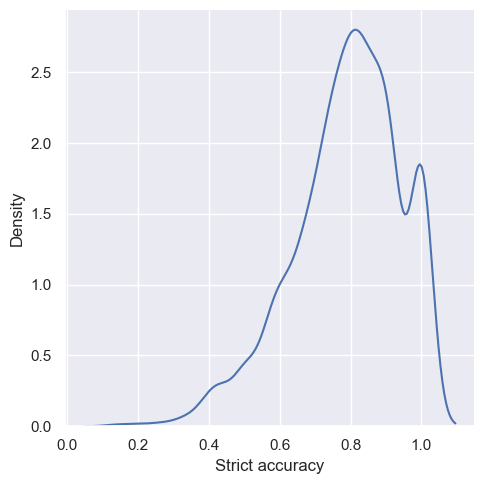

In [ ]:
# ax = sns.(data=df_res)
# ax.set(xlabel='Strict accuracy', ylabel='', title='Strict accuracy distribution')
# ax.set(yticklabels=[])

sns.displot(data=df_res, x="Strict accuracy", kind="kde")

# plt.show()

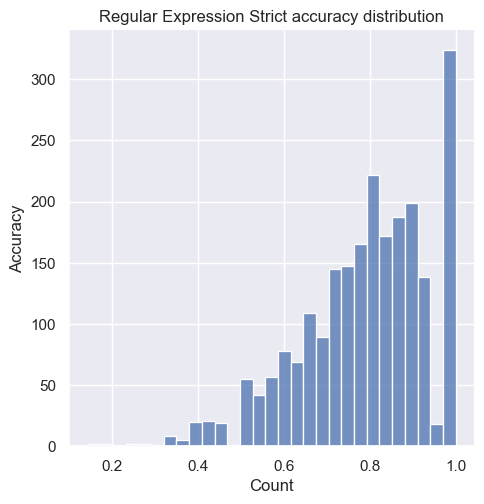

In [33]:
plot = sns.displot(data=df_res, x="Strict accuracy")
plot.set(xlabel ="Count", ylabel = "Accuracy", title ='Regular Expression Strict accuracy distribution')
plt.show()

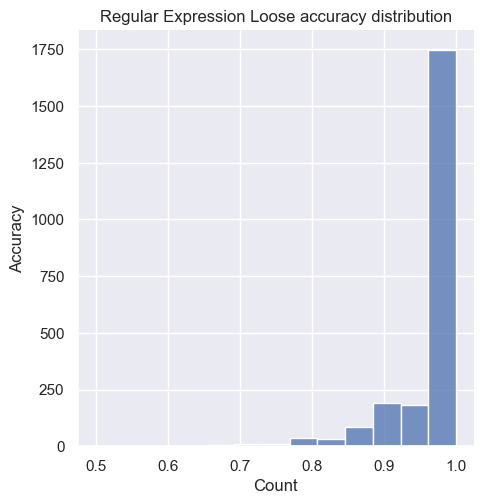

In [34]:
plot = sns.displot(data=df_res, x="Loose accuracy")
plot.set(xlabel ="Count", ylabel = "Accuracy", title ='Regular Expression Loose accuracy distribution')
plt.show()